In [2]:
import torch 
from torch import nn
import torch.nn.functional as F
import math


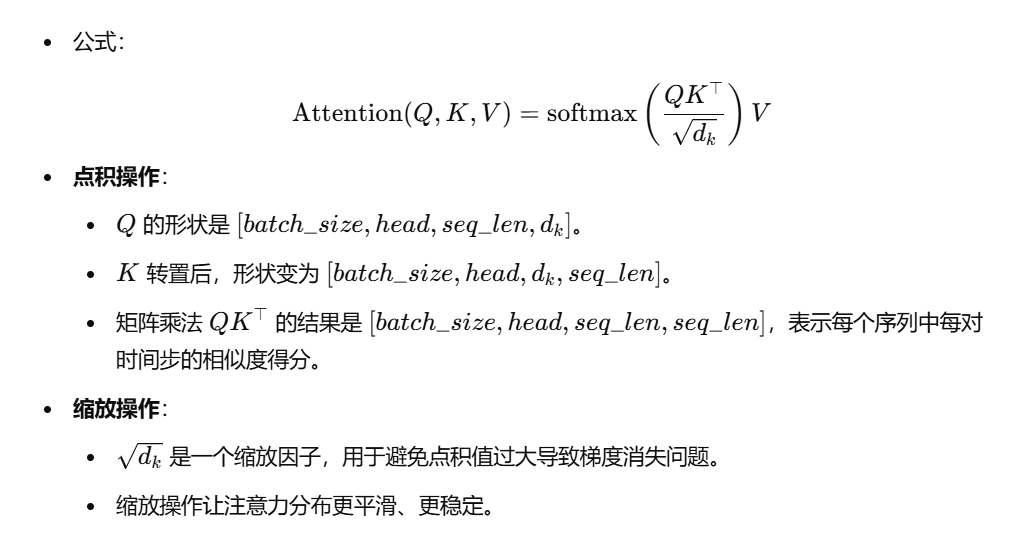

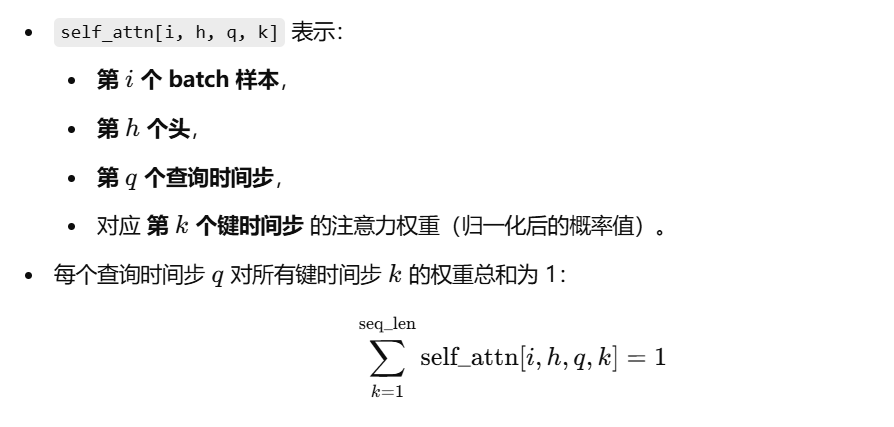

In [ ]:
def self_attention(query, key, value, dropout = None, mask = None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # mask的操作在QK之后，softmax之前
    if mask is not None:
        mask.cuda()
        scores = scores.masked_fill(mask == 0, -1e9)
    self_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        self_attn = dropout(self_attn)
    # 乘上 V 矩阵  形状 变为 [batch_size, head, seq_len, seq_len] @ [batch_size, head, seq_len, d_k] 变为 原形状
    return torch.matmul(self_attn, value), self_attn

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()

    def forward(self, head, d_model, query, key, value, dropout = 0.1, mask = None):
        """
        :param head: 头数，默认 8
        :param d_model: 输入的维度 512
        :param query: Q
        :param key: K
        :param value: V
        :param dropout:
        :param mask:
        :return:
        """
        assert (d_model % head == 0)
        self.d_k = d_model // head
        self.head = head
        self.d_model = d_model
        
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        # 自注意力机制的 QKV 同源，线性变换
        self.linear_out = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(p = dropout)
        self.attn = None

        # 多头需要对这个 X 切分成多头

        # query==key==value
        # [b,1,512]
        # [b,8,1,64]

        # [b,32,512]
        # [b,8,32,64]
        n_batch = query.size(0)
        # .transpose(1, 2) 不改变张量的数据本质，而是交换了 第 1 维和第 2 维 的逻辑顺序 view 尽量划分 相邻维度 再通过 transpose 调整逻辑顺序
        query = self.linear_query(query).view(n_batch, -1, self.head, self.d_k).transpose(1, 2)
        key = self.linear_key(key).view(n_batch, -1, self.head, self.d_k).transpose(1, 2)
        value = self.linear_value(value).view(n_batch, -1, self.head, self.d_k).transpose(1, 2)
        
        #  这里 q 的形状 是 [batch_size, head, seq_len, d_k]
        # 到这里 多头部分结束 开始 自注意力(每一头 分别计算自注意力)
        x, self.attn = self_attention(query, key, value, dropout=self.dropout, mask=mask)
        # 注意 contiguous 创建 内存连续的 副本
        x = x.transpose(1, 2).contiguous().view(n_batch, -1, self.head * self.d_k)
        # 通过拼接形成的结果，只是将多个头的结果整合在一起，尚未学习到如何有效融合不同头的特征。 
        # #self.linear_out 的作用： 学习一个线性组合，将不同头的特征融合。
        return self.linear_out(x)
